# Adversarial Search: Solving Tic-Tac-Toe with Heuristic Alpha-Beta Tree Search

## Introduction 

Multiplayer games can be implemented as:
1. Nondeterministic actions: The opponent is seen as part of an environment with nondeterministic actions. Non-determinism is the result of the unknown opponent's moves. 
2. Optimal Decisions: Minimax search (search complete game tree) and alpha-beta pruning.
3. __Heuristic Alpha-Beta Tree Search:__ Cut off tree search and use heuristic to estimate state value. 
4. Monte Carlo Tree search: Simulate playouts to estimate state value. 

Here we will implement search for Tic-Tac-Toe (see [rules](https://en.wikipedia.org/wiki/Tic-tac-toe)). The game is a __zero-sum game__: Win by x results in +1, win by o in -1 and a tie has a value of 0. Max plays x and tries to maximize the outcome while Min plays o and tries to minimize the outcome.   

We will implement
* Heuristic Alpha-Beta Tree Search

The algorithms search the game tree and we could return a conditional plan (or partial plan if cut offs are used), but the implementation here only identifies and returns the optimal next move.

The code for the basic functions used for search are implemented in [tictactoe.py](tictactoe.py).

In [1]:
from tictactoe import empty_board, actions, result, terminal, utility, other, show_board
from tictactoe import random_player, play 

# Heuristic Alpha-Beta Tree Search

See AIMA page 156ff. 


## Heuristic Evaluation Function

In [4]:
import numpy as np

def eval_fun(state, player = 'x'):
    """heuristic for utility of state. Returns score for a node:
    1. For terminal states it returns the utility. 
    2. For non-terminal states, it calculates a weighted linear function using features of the state. 
    The features we look at are 2 in a row/col/diagonal where the 3rd square is empty. We assume that
    the more of these positions we have, the higher the chance of winning.
    We need to be careful that the utility of the heuristic stays between [-1,1]. 
    Note that the largest possible number of these positions is 2. I weigh the count by 0.4, 
    guaranteeing that is in the needed range.
    
    Function Returns: heuristic value, terminal?"""
    
    # terminal state?
    u = utility(state, player)
    if u is not None: return u, True
      
    score = 0
    board = np.array(state).reshape((3,3))
    diagonals = np.array([[board[i][i] for i in range(len(board))], 
                          [board[i][len(board)-i-1] for i in range(len(board))]])
    
    for a_board in [board, np.transpose(board), diagonals]:
        for row in a_board:
            if sum(row == player) == 2 and any(row ==' '): score += .4
            if sum(row == other(player)) == 2 and any(row ==' '): score -= .4
    
    return score, False

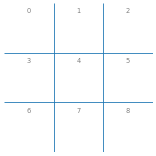

eval for x: (0, False)
eval for o: (0, False)


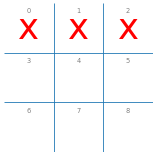

eval for x: (1, True)
eval for o: (-1, True)


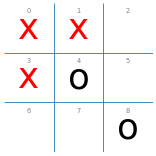

eval for x: (0.8, False)
eval for o: (-0.8, False)


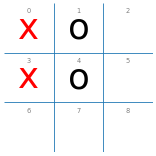

eval for x: (0.0, False)
eval for o: (0.0, False)


In [5]:
board = empty_board() 
show_board(board)
print(f"eval for x: {eval_fun(board)}")
print(f"eval for o: {eval_fun(board, 'o')}")

board = empty_board() 
board[0] = 'x'
board[1] = 'x'
board[2] = 'x' 
show_board(board)
print(f"eval for x: {eval_fun(board)}")
print(f"eval for o: {eval_fun(board, 'o')}")

board = empty_board() 
board[0] = 'x'
board[1] = 'x'
board[3] = 'x' 
board[4] = 'o'
board[8] = 'o'
show_board(board)
print(f"eval for x: {eval_fun(board)}")
print(f"eval for o: {eval_fun(board, 'o')}")

board = empty_board() 
board[0] = 'x'
board[1] = 'o'
board[3] = 'x' 
board[4] = 'o'
show_board(board)
print(f"eval for x: {eval_fun(board)}")
print(f"eval for o: {eval_fun(board, 'o')}")

## Search with Cutoff

We add a cutoff to the Recursive DFS algorithm for Minimax Search with Alpha-Beta Pruning (see AIMA page 156ff). We use the heuristic evaluation function and the back-up the value using minimax search with alpha-beta pruning to determine the next move.

In [8]:
import math

# global variables
DEBUG = 1 # 1 ... count nodes, 2 ... debug each node
COUNT = 0

def alpha_beta_search(board, cutoff = None, player = 'x'):
    """start the search. cutoff = None is minimax search with alpha-beta pruning."""
    global DEBUG, COUNT
    COUNT = 0

    value, move = max_value_ab(board, player, -math.inf, +math.inf, 0, cutoff)
    
    if DEBUG >= 1: print(f"Number of nodes searched (cutoff = {cutoff}): {COUNT}") 
    
    return {"move": move, "value": value}

def max_value_ab(state, player, alpha, beta, depth, cutoff):
    """player's best move."""
    global DEBUG, COUNT
    COUNT += 1
    
    # cut off and terminal test
    v, terminal = eval_fun(state, player)
    if((cutoff is not None and depth >= cutoff) or terminal): 
        if(terminal): 
            alpha, beta = v, v
        if DEBUG >= 2: print(f"stopped at {depth}: {state} term: {terminal} eval: {v} [{alpha}, {beta}]" ) 
        return v, None
    
    v, move = -math.inf, None

    # check all possible actions in the state, update alpha and return move with the largest value
    for a in actions(state):
        v2, a2 = min_value_ab(result(state, player, a), player, alpha, beta, depth + 1, cutoff)
        if v2 > v:
            v, move = v2, a
            alpha = max(alpha, v)
        if v >= beta: return v, move
    
    return v, move

def min_value_ab(state, player, alpha, beta, depth, cutoff):
    """opponent's best response."""
    global DEBUG, COUNT
    COUNT += 1
    
    # cut off and terminal test
    v, terminal = eval_fun(state, player)
    if((cutoff is not None and depth >= cutoff) or terminal): 
        if(terminal): 
            alpha, beta = v, v
        if DEBUG >= 2: print(f"stopped at {depth}: {state} term: {terminal} eval: {v} [{alpha}, {beta}]" ) 
        return v, None
    
    v, move = +math.inf, None

    # check all possible actions in the state, update beta and return move with the smallest value
    for a in actions(state):
        v2, a2 = max_value_ab(result(state, other(player), a), player, alpha, beta, depth + 1, cutoff)
        if v2 < v:
            v, move = v2, a
            beta = min(beta, v)
        if v <= alpha: return v, move
    
    return v, move

## Some Tests

### x is about to win (play 8)

Board:


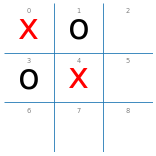


Number of nodes searched (cutoff = 2): 13


{'move': 8, 'value': 1}

CPU times: user 2.84 ms, sys: 2.62 ms, total: 5.46 ms
Wall time: 1.79 ms

Number of nodes searched (cutoff = 4): 47


{'move': 2, 'value': 1}

CPU times: user 7.77 ms, sys: 3.76 ms, total: 11.5 ms
Wall time: 3.82 ms

Number of nodes searched (cutoff = None): 61


{'move': 2, 'value': 1}

CPU times: user 7.86 ms, sys: 3.84 ms, total: 11.7 ms
Wall time: 3.92 ms


In [9]:
board = empty_board() 
board[0] = 'x'
board[1] = 'o'
board[3] = 'o'
board[4] = 'x'

print("Board:")
show_board(board)

print()
%time display(alpha_beta_search(board, 2))

print()
%time display(alpha_beta_search(board, 4))

print()
%time display(alpha_beta_search(board))

### o is about to win

Board:


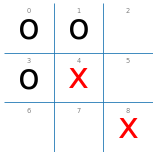


Number of nodes searched (cutoff = 2): 11


{'move': 2, 'value': -1}

CPU times: user 3.79 ms, sys: 7.83 ms, total: 11.6 ms
Wall time: 3.87 ms

Number of nodes searched (cutoff = None): 15


{'move': 2, 'value': -1}

CPU times: user 8.43 ms, sys: 4.38 ms, total: 12.8 ms
Wall time: 4.2 ms


In [10]:
board = empty_board() 
board[0] = 'o'
board[1] = 'o'
board[3] = 'o'
board[4] = 'x'
board[8] = 'x'

print("Board:")
show_board(board)

print()
%time display(alpha_beta_search(board, 2))
print()
%time display(alpha_beta_search(board))

### x can draw if it chooses 7

Board:


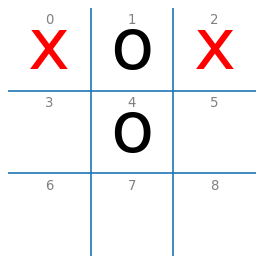


Number of nodes searched (cutoff = 2): 21


{'move': 7, 'value': -0.4}

CPU times: user 21.4 ms, sys: 5.45 ms, total: 26.8 ms
Wall time: 8.81 ms

Number of nodes searched (cutoff = 4): 81


{'move': 7, 'value': 0}

CPU times: user 54.9 ms, sys: 26.7 ms, total: 81.5 ms
Wall time: 26.9 ms

Number of nodes searched (cutoff = None): 101


{'move': 7, 'value': 0}

CPU times: user 66 ms, sys: 67.7 ms, total: 134 ms
Wall time: 48.6 ms


In [14]:
board = empty_board() 
board[0] = 'x'
board[1] = 'o'
board[2] = 'x'
board[4] = 'o'

print("Board:")
show_board(board)

print()
%time display(alpha_beta_search(board, 2))
print()
%time display(alpha_beta_search(board, 4))
print()
%time display(alpha_beta_search(board))

### Empty board: Only a draw an be guaranteed

Board:


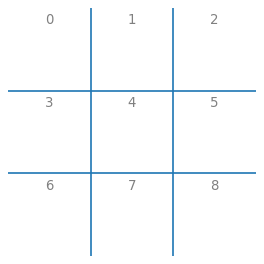


Number of nodes searched (cutoff = 2): 26


{'move': 0, 'value': 0}

CPU times: user 14.4 ms, sys: 13.8 ms, total: 28.1 ms
Wall time: 9.28 ms

Number of nodes searched (cutoff = 4): 541


{'move': 4, 'value': 0.0}

CPU times: user 301 ms, sys: 112 ms, total: 413 ms
Wall time: 182 ms

Number of nodes searched (cutoff = None): 18297


{'move': 0, 'value': 0}

CPU times: user 3.76 s, sys: 0 ns, total: 3.76 s
Wall time: 3.76 s


In [15]:
board = empty_board() 

print("Board:")
show_board(board)


print()
%time display(alpha_beta_search(board, 2))
print()
%time display(alpha_beta_search(board, 4))
print()
%time display(alpha_beta_search(board))

### A bad situation

Board:


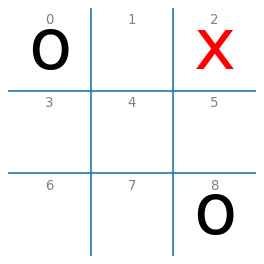


Number of nodes searched (cutoff = 2): 29


{'move': 4, 'value': -0.8}

CPU times: user 20.1 ms, sys: 11.1 ms, total: 31.2 ms
Wall time: 10.3 ms

Number of nodes searched (cutoff = 4): 148


{'move': 1, 'value': -1}

CPU times: user 81.4 ms, sys: 40.3 ms, total: 122 ms
Wall time: 40.5 ms

Number of nodes searched (cutoff = None): 238


{'move': 1, 'value': -1}

CPU times: user 126 ms, sys: 44.6 ms, total: 171 ms
Wall time: 56.8 ms


In [16]:
board = empty_board() 
board[0] = 'o'
board[2] = 'x'
board[8] = 'o'

print("Board:")
show_board(board)

print()
%time display(alpha_beta_search(board, 2))
print()
%time display(alpha_beta_search(board, 4))
print()
%time display(alpha_beta_search(board))

## Experiments



### Minimax with Alpha-Beta Pruning vs. Random

In [11]:
def heuristic2_player(board, player = 'x'):
    return alpha_beta_search(board, cutoff = 2, player = player)["move"]

def heuristic4_player(board, player = 'x'):
    return alpha_beta_search(board, cutoff = 4, player = player)["move"]

def alpha_beta_player(board, player = 'x'):
    return alpha_beta_search(board, cutoff = None, player = player)["move"]

DEBUG = 1
print("heuristic2 vs. random:")
display(play(heuristic2_player, random_player, N = 3))

heuristic2 vs. random:
Number of nodes searched (cutoff = 2): 26
Number of nodes searched (cutoff = 2): 30
Number of nodes searched (cutoff = 2): 10
Number of nodes searched (cutoff = 2): 26
Number of nodes searched (cutoff = 2): 33
Number of nodes searched (cutoff = 2): 16
Number of nodes searched (cutoff = 2): 26
Number of nodes searched (cutoff = 2): 30
Number of nodes searched (cutoff = 2): 10


{'x': 3, 'o': 0, 'd': 0}

In [12]:
DEBUG = 0
print("heuristic2 vs. random:")
%time display(play(heuristic2_player, random_player))

print("heuristic4 vs. random:")
%time display(play(heuristic4_player, random_player))

print()
print("random vs. heuristic2")
%time display(play(random_player, heuristic2_player))

print("random vs. heuristic4")
%time display(play(random_player, heuristic4_player))

heuristic2 vs. random:


{'x': 93, 'o': 0, 'd': 7}

CPU times: user 393 ms, sys: 1.38 ms, total: 394 ms
Wall time: 387 ms
heuristic4 vs. random:


{'x': 99, 'o': 0, 'd': 1}

CPU times: user 4.92 s, sys: 0 ns, total: 4.92 s
Wall time: 4.92 s

random vs. heuristic2


{'x': 1, 'o': 87, 'd': 12}

CPU times: user 375 ms, sys: 0 ns, total: 375 ms
Wall time: 367 ms
random vs. heuristic4


{'x': 0, 'o': 81, 'd': 19}

CPU times: user 3.29 s, sys: 0 ns, total: 3.29 s
Wall time: 3.29 s


### Heuristic vs. Minimax with Alpha-Beta Pruning

In [13]:
DEBUG = 0

# Note: No randomness -> play only once

print("heuristic2 vs. alpha_beta")
%time display(play(heuristic2_player, alpha_beta_player, N = 1))

print()
print("alpha_beta vs. heuristic2")
%time display(play(alpha_beta_player, heuristic2_player, N = 1))

print()
print("heuristic4 vs alpha_beta")
%time display(play(heuristic4_player, alpha_beta_player, N = 1))

print()
print("alpha_beta vs. heuristic4")
%time display(play(alpha_beta_player, heuristic4_player, N = 1))

heuristic2 vs. alpha_beta


{'x': 0, 'o': 0, 'd': 1}

CPU times: user 131 ms, sys: 0 ns, total: 131 ms
Wall time: 130 ms

alpha_beta vs. heuristic2


{'x': 1, 'o': 0, 'd': 0}

CPU times: user 822 ms, sys: 0 ns, total: 822 ms
Wall time: 822 ms

heuristic4 vs alpha_beta


{'x': 0, 'o': 0, 'd': 1}

CPU times: user 179 ms, sys: 0 ns, total: 179 ms
Wall time: 179 ms

alpha_beta vs. heuristic4


{'x': 0, 'o': 0, 'd': 1}

CPU times: user 973 ms, sys: 0 ns, total: 973 ms
Wall time: 973 ms


### Heuristic vs. Heuristic

In [14]:
DEBUG = 0

# Note: No randomness -> play only once

print("heuristic2 vs. heuristic4")
%time display(play(heuristic2_player, heuristic4_player, N = 1))

print()
print("heuristic4 vs. heuristic2")
%time display(play(heuristic4_player, heuristic2_player, N = 1))

heuristic2 vs. heuristic4


{'x': 0, 'o': 0, 'd': 1}

CPU times: user 27.5 ms, sys: 0 ns, total: 27.5 ms
Wall time: 27.1 ms

heuristic4 vs. heuristic2


{'x': 0, 'o': 0, 'd': 1}

CPU times: user 51.1 ms, sys: 0 ns, total: 51.1 ms
Wall time: 50.7 ms


__Idea:__ Start experiments with different boards that already have a few x's and o's randomly placed on them.